In [12]:
%matplotlib inline
import numpy as np
from skyfield.api import load, Topos
from scipy.optimize import newton
from matplotlib import pyplot as plt
planets = load('de423.bsp')

In [13]:
class plutino:
    """
    generate plutinos
    units: au, radius
    
    """
    def __init__(self, size = 1000, mjd = 57023):
        self.size = size
        self.mjd = mjd
        self.lambda_N = 0
        self.a = self.gen_a()
        self.e = self.gen_e()
        self.i = self.gen_i()
        self.amp = self.gen_amp()
        self.phi = self.gen_phi(self.amp)
        self.M = self.gen_M()
        self.node = self.gen_node()
        self.arg = self.gen_arg(self.phi, self.M, self.node, self.lambda_N)
        self.X, self.Y, self.Z = zip(*map(self.kep_to_xyz, self.a, self.e, self.i, self.arg, self.node, self.M))
        self.xyz_to_equa(self.X, self.Y, self.Z)
    
    def gen_a(self):
        return 39.45 + np.random.random(self.size) * 0.4 - 0.2
        
    def gen_e(self):
        return np.random.normal(loc=0.175, scale=0.06, size = self.size)
        
    def gen_i(self):
        return np.arcsin(np.random.rayleigh(scale = 12 * np.pi/180., size = self.size))
        
    def gen_amp(self):
        return np.random.triangular(0, 75, 155, size = self.size) * np.pi / 180.
    
    def gen_phi(self, amp):
        return np.pi + amp * np.sin(2*np.pi*np.random.random(self.size))
        
    def gen_M(self):
        return 4*np.pi*np.random.random(self.size)
        
    def gen_node(self):
        return 2*np.pi*np.random.random(self.size)
        
    def gen_arg(self, phi, M, node, lambda_N):
        return 0.5*phi - 1.5*M - node + lambda_N
        
    def gen_H(self):
        alpha = 0.9
        h0 = 0
        h1 = 10
        h0s10 = 10**(alpha*h0)
        h1s10 = 10**(alpha*h1)
        return np.log10(np.random.random(self.size)*(h1s10-h0s10) + h0s10) / alpha
        
    def kep_to_xyz(self, a, e, i, arg, node, M):
        # compute eccentric anomaly
        f = lambda E, M, e: E - e * np.sin(E) - M
        E0 = M
        E = newton(f, E0, args=(M, e))
        # compute true anomaly
        v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
        # compute the radius
        r = a * (1 - e*np.cos(E))
        # compute X,Y,Z
        X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
        Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
        Z = r * (np.sin(i) * np.sin(arg + v))
        return X, Y, Z
        
    def xyz_to_equa(self, X0, Y0, Z0):
        earth = planets['earth']
        ts = load.timescale()
        t = ts.tai(jd=self.mjd+2400000.500428) #37 leap seconds
        epsilon =  23.43694 * np.pi/180.
        x_earth, y_earth, z_earth = earth.at(t).position.au
        X = np.array(X0) - x_earth
        Y = np.array(Y0) * np.cos(epsilon) + np.array(Z0) * np.sin(epsilon)  - y_earth
        Z = np.array(Y0) * np.sin(epsilon) - np.array(Z0) * np.cos(epsilon) - z_earth
        self.dec = np.arcsin(Z/(X**2+Y**2+Z**2)**0.5)
        self.ra = np.arctan2(Y, X) % (2*np.pi)

In [14]:
p = plutino(size = 2000)

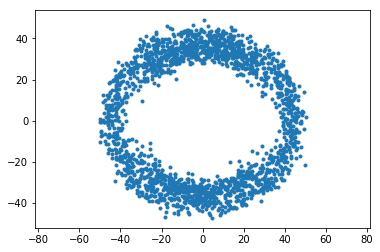

In [15]:
plt.axis('equal')
plt.scatter(p.X,p.Y, marker = '.')

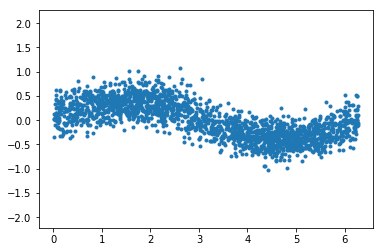

In [16]:
plt.axis('equal')
plt.scatter(p.ra,p.dec, marker = '.')